# Quantify how often clusters occurs across distant parts of the primary sequence

In [3]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os

sys.path.append('../../')
from global_variables import SUBDIR, RUN, WORKSPACE

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
# Get genes detected by O3D
canonical_metadata = pd.read_table(f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_240506/seq_for_mut_prob.tsv")
canonical_metadata = canonical_metadata[["Gene", "Uniprot_ID"]].drop_duplicates().reset_index(drop=True)

genetable = pd.read_table(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/{SUBDIR}/{RUN}.genetable.tsv")
genetable = genetable[["Gene", "CGC", "Fish", "o3d_qval"]]
genetable = genetable[genetable["o3d_qval"] < 0.01].reset_index(drop=True)
genetable = genetable[["Gene", "CGC"]].drop_duplicates()
genetable = genetable.merge(canonical_metadata, on="Gene", how="left")
genetable

,Gene,CGC,Uniprot_ID
0,PIK3CA,1,P42336
1,RXRA,0,P19793
2,FGFR3,1,P22607
3,FBXW7,1,Q969H0
4,TP53,1,P04637
...,...,...,...
268,CNBD1,1,Q8NA66
269,CDH1,1,P12830
270,TRIM49C,0,P0CI26
271,SPTA1,0,P02549


## Check at cluster level

In [5]:
def get_all_o3d_res_result(cohort_df, o3d_output_dir):

    lst_df = []

    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            cols = ["Cohort", "Gene", "Pos", "Mut_in_gene", "Score", "Score_obs_sim", "pval", "Rank", "Res_in_cl", 'C', 'C_ext']
            df_o3d = df_o3d[cols].dropna(subset=["pval"]).reset_index(drop=True)
            #df_o3d = df_o3d.reset_index().rename(columns={"index": "Rank"})
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df = df.sort_values(["Cohort", "Gene", "Pos"], ascending=[False, True, True]).reset_index(drop=True)

    return df


def get_all_o3d_gene_result(cohort_df, o3d_output_dir):

    lst_df = []
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "C_pos", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene"]].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df = df.sort_values(["Cohort", "pval"], ascending=[False, True])

    return df.reset_index(drop=True)


def get_cgc_action(gene_action):

    if pd.isnull(gene_action):
        return "Ambiguous"
        
    gene_action = [action.strip() for action in gene_action.split(",")]

    if len(gene_action) == 1:
        if gene_action[0] == "oncogene":
            action = "Oncogene"
        elif gene_action[0] == "TSG":
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
        
    else:
        if "oncogene" in gene_action and "TSG" in gene_action:
            action = "Ambiguous"
        elif "oncogene" in gene_action:
            action = "Oncogene"
        elif "TSG" in gene_action:
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
    
    return action


def load_cmap(path, uni_id, f):

    cmap = np.load(f"{path}/{uni_id}-F{f}.npy")
    return (cmap > 0.5).astype(int)


def get_contact(cmap, x):
    return np.where(cmap[x] == 1)[0]


def get_non_contiguous_contacts(df, cutoff=1):
    
    return df['Contacts'].apply(lambda x: bool(np.any(np.diff(x) > cutoff)))


def get_max_contact_gap(df):

    return df['Contacts'].apply(
        lambda x: int(np.max(np.diff(x))) if len(x) > 1 else 0
    )


In [6]:
datasets = f"/{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

df_genes = get_all_o3d_gene_result(cohort_df, o3d_output_dir)
df_res = get_all_o3d_res_result(cohort_df, o3d_output_dir)
df_res

Path doesn't exist: //data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv
Path doesn't exist: //data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_pos.csv


,Cohort,Gene,Pos,Mut_in_gene,Score,Score_obs_sim,pval,Rank,Res_in_cl,C,C_ext
0,TCGA_WXS_WDTC,ABHD4,106,3,0.519823,0.991012,0.377,1,NaN,0,NaN
1,TCGA_WXS_WDTC,ABHD4,236,3,0.228704,0.463615,1.0,2,NaN,0,NaN
2,TCGA_WXS_WDTC,ABHD4,245,3,0.531449,0.931628,0.4611,0,NaN,0,NaN
3,TCGA_WXS_WDTC,ADPGK,495,2,1.0,1.437695,0.1367,0,NaN,0,NaN
4,TCGA_WXS_WDTC,AKT1,17,5,0.4821,1.433858,0.0754,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
616645,CBIOP_WGS_PRAD_EURUROL_2017,SPOP,133,11,0.381369,2.851625,0.00001,3,5.0,1,0.0
616646,CBIOP_WGS_PRAD_EURUROL_2017,SUN5,334,2,1.0,1.48961,0.1163,0,NaN,0,NaN
616647,CBIOP_WGS_PRAD_EURUROL_2017,TFAP4,289,2,1.0,1.703566,0.058,0,NaN,0,NaN
616648,CBIOP_WGS_PRAD_EURUROL_2017,TNKS2,341,2,1.0,1.716158,0.0497,0,NaN,0,NaN


In [7]:
cgc_df = pd.read_csv(f"{datasets}input/cancer_202404/CGC_list_v99.tsv", sep = "\t")
cgc_df = cgc_df[["Gene Symbol", "Role in Cancer"]].rename(columns={
    "Gene Symbol" : "Gene", 
    "Role in Cancer" : "Gene_action"})
cgc_df.Gene_action = cgc_df.Gene_action.apply(lambda x: get_cgc_action(x))
cgc_df = cgc_df.assign(Gene=cgc_df['Gene'].str.split(','))
cgc_df = cgc_df.explode('Gene')
cgc_df['Gene'] = cgc_df['Gene'].str.strip()
cgc_df.loc[cgc_df["Gene"] == "TP53", "Gene_action"] = "Tumour suppressor"
cgc_df

,Gene,Gene_action
0,A1CF,Oncogene
1,ABI1,Tumour suppressor
2,ABL1,Oncogene
3,ABL2,Oncogene
4,ACKR3,Oncogene
...,...,...
738,ZNF429,Ambiguous
739,ZNF479,Ambiguous
740,ZNF521,Oncogene
741,ZNRF3,Tumour suppressor


In [8]:
genes_hit = df_genes[df_genes["qval"] < 0.01].reset_index(drop=True)
genes_hit['Cohort_Gene'] = genes_hit['Cohort'] + '|' + genes_hit['Gene']
genes_hit

,Gene,Uniprot_ID,Cohort,pval,qval,C_pos,Score_obs_sim_top_vol,Mut_in_top_vol,Mut_in_gene,Cohort_Gene
0,BRAF,P15056,TCGA_WXS_WDTC,0.00001,0.0,[601 600],179.618281,287.0,287,TCGA_WXS_WDTC|BRAF
1,NRAS,P01111,TCGA_WXS_WDTC,0.00001,0.0,[61],15.507143,39.0,39,TCGA_WXS_WDTC|NRAS
2,HRAS,P01112,TCGA_WXS_WDTC,0.00001,0.0,[61],7.066159,17.0,17,TCGA_WXS_WDTC|HRAS
3,GNAQ,A0A024R240,TCGA_WXS_UM,0.00001,0.0,[209 48],18.591696,38.0,40,TCGA_WXS_UM|GNAQ
4,GNA11,P29992,TCGA_WXS_UM,0.00001,0.0,[209],14.753669,34.0,36,TCGA_WXS_UM|GNA11
...,...,...,...,...,...,...,...,...,...,...
614,G3BP1,Q13283,CBIOP_WXS_ANGS_TREATED_2020,0.00001,0.0,[4 5],3.180288,4.0,4,CBIOP_WXS_ANGS_TREATED_2020|G3BP1
615,RETSAT,Q6NUM9,CBIOP_WXS_ACY_2019,0.00001,0.0,[533 536],3.745953,6.0,6,CBIOP_WXS_ACY_2019|RETSAT
616,NOTCH2,Q04721,CBIOP_WXS_ACY_2019,0.00001,0.0,[3],3.656038,4.0,4,CBIOP_WXS_ACY_2019|NOTCH2
617,TP53,K7PPA8,CBIOP_WGS_STAD_ONCOSG_2018,0.00001,0.0,[239 242 245 236 248 273 175 195 237 179 132 2...,7.151944,26.0,47,CBIOP_WGS_STAD_ONCOSG_2018|TP53


In [9]:
cmaps = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506/prob_cmaps"
seq_df = pd.read_table(f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506/seq_for_mut_prob.tsv")
seq_df = seq_df[seq_df.Gene.isin(genes_hit.Gene)].reset_index(drop=True)[["Gene", "Uniprot_ID", "F"]]
seq_df

,Gene,Uniprot_ID,F
0,ZNF93,P35789,1
1,ZNF91,Q05481,1
2,ZNF880,Q6PDB4,1
3,ZNF83,P51522,1
4,ZNF804A,Q7Z570,1
...,...,...,...
268,AHNAK,Q09666,24M
269,AGAP6,Q5VW22,1
270,ADH4,P08319,1
271,ADGRV1,Q8WXG9,26M


In [10]:
df_res['Cohort_Gene'] = df_res['Cohort'] + '|' + df_res['Gene']
df_res = df_res[df_res.Cohort_Gene.isin(genes_hit.Cohort_Gene)]
df_res = df_res[df_res["C"] == 1].reset_index(drop=True)
df_res['Cohort_Gene'] = df_res['Cohort_Gene'] + '|' + df_res['Pos'].astype(str)
df_res

,Cohort,Gene,Pos,Mut_in_gene,Score,Score_obs_sim,pval,Rank,Res_in_cl,C,C_ext,Cohort_Gene
0,TCGA_WXS_WDTC,BRAF,600,287,1.0,179.618281,0.00001,1,2.0,1,0.0,TCGA_WXS_WDTC|BRAF|600
1,TCGA_WXS_WDTC,BRAF,601,287,1.0,159.730994,0.00001,0,2.0,1,0.0,TCGA_WXS_WDTC|BRAF|601
2,TCGA_WXS_WDTC,HRAS,61,17,1.0,7.066159,0.00001,0,1.0,1,0.0,TCGA_WXS_WDTC|HRAS|61
3,TCGA_WXS_WDTC,NRAS,61,39,1.0,15.507143,0.00001,0,1.0,1,0.0,TCGA_WXS_WDTC|NRAS|61
4,TCGA_WXS_UM,GNA11,209,36,0.880534,14.753669,0.00001,0,1.0,1,0.0,TCGA_WXS_UM|GNA11|209
...,...,...,...,...,...,...,...,...,...,...,...,...
4111,CBIOP_WGS_PRAD_EURUROL_2017,SPOP,87,11,0.840076,5.499366,0.00001,1,5.0,1,0.0,CBIOP_WGS_PRAD_EURUROL_2017|SPOP|87
4112,CBIOP_WGS_PRAD_EURUROL_2017,SPOP,102,11,0.448503,3.155023,0.00001,2,5.0,1,0.0,CBIOP_WGS_PRAD_EURUROL_2017|SPOP|102
4113,CBIOP_WGS_PRAD_EURUROL_2017,SPOP,125,11,0.12842,1.013015,0.3533,4,5.0,1,1.0,CBIOP_WGS_PRAD_EURUROL_2017|SPOP|125
4114,CBIOP_WGS_PRAD_EURUROL_2017,SPOP,131,11,1.0,5.947184,0.00001,0,5.0,1,0.0,CBIOP_WGS_PRAD_EURUROL_2017|SPOP|131


In [11]:
# df_res = pd.read_csv("data/df_res.csv")
# genes_hit = pd.read_csv("data/genes_hit.csv")

In [12]:
# df_res.to_csv("data/df_res.csv", index=False)
# genes_hit.to_csv("data/genes_hit.csv", index=False)

In [13]:
# df_res_sorted = df_res.sort_values(["Gene", "Pos"]).reset_index(drop=True)
# clusters = df_res_sorted["Gene"] + "|" + df_res_sorted["Pos"].astype(str)
# clusters = clusters.unique()
# clusters_dict = {}

# current_gene = ""
# for cluster in tqdm(clusters):
#     gene, pos = cluster.split("|")
#     pos = int(pos)
#     _, uni_id, f = seq_df[seq_df["Gene"] == gene].values[0]
#     if gene != current_gene:
#         clusters_dict[gene] = {}
#         cmap = load_cmap(cmaps, uni_id, f)
#         current_gene = gene
#     clusters_dict[gene][pos] = get_contact(cmap, pos-1)

In [14]:
# For each cluster (Cohort | Gene | Pos) get the mutated residues in contact in that cohort
# Consider only cluster (C = 1, i.e., qval < 0.01 or providing mut to a res with qval < 0.01) from detected genes

df_res = df_res.sort_values(["Gene", "Cohort"]).reset_index(drop=True)

clusters_cohort_dict = {}
current_gene = ""
for group, df in tqdm(df_res.groupby(["Gene", 'Cohort'])):
    gene, cohort = group
    all_pos = df.Pos.values
    
    _, uni_id, f = seq_df[seq_df["Gene"] == gene].values[0]
    if gene != current_gene:
        cmap = load_cmap(cmaps, uni_id, f)
        current_gene = gene
    
    # Get contacts among the mutated positions
    for row in df.itertuples():
        cluster = row.Cohort_Gene
        contacts = [p for p in get_contact(cmap, row.Pos-1) if p in all_pos] 
        clusters_cohort_dict[cluster] = contacts
        
df_res["Contacts"] = df_res.Cohort_Gene.map(clusters_cohort_dict)
df_res = df_res.drop(columns=["Cohort_Gene"])
df_res["Max_distance"] = get_max_contact_gap(df_res)
df_res = df_res.merge(cgc_df, on="Gene", how="left")
df_res

100%|██████████| 619/619 [00:42<00:00, 14.67it/s]


,Cohort,Gene,Pos,Mut_in_gene,Score,Score_obs_sim,pval,Rank,Res_in_cl,C,C_ext,Contacts,Max_distance,Gene_action
0,PEDCBIOP_WXS_HGG_PRY,ACVR1,328,12,0.445998,2.993457,0.00001,0,1.0,1,0.0,[328],0,Oncogene
1,PCAWG_WGS_LIVER_HCC,ADGRV1,4500,24,0.164718,3.056457,0.00001,1,4.0,1,0.0,"[4500, 4501]",1,NaN
2,PCAWG_WGS_LIVER_HCC,ADGRV1,4501,24,0.164454,3.15831,0.00001,2,4.0,1,0.0,"[4500, 4501]",1,NaN
3,PCAWG_WGS_LIVER_HCC,ADGRV1,4503,24,0.197258,3.503474,0.00001,0,4.0,1,0.0,"[4500, 4501, 4503, 4504]",2,NaN
4,PCAWG_WGS_LIVER_HCC,ADGRV1,4504,24,0.132344,2.600894,0.00001,3,4.0,1,0.0,"[4501, 4503, 4504]",2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4111,CBIOP_WXS_BLCA_BGI,ZNF83,290,25,0.796957,12.892111,0.00001,1,2.0,1,0.0,"[290, 293]",3,NaN
4112,CBIOP_WXS_BLCA_BGI,ZNF83,293,25,0.802778,11.857008,0.00001,0,2.0,1,0.0,"[290, 293]",3,NaN
4113,CBIOP_WXS_LUAD_ONCOSG_2020,ZNF880,406,5,1.0,3.60575,0.00001,0,1.0,1,0.0,[406],0,NaN
4114,OTHER_WXS_NPC_NATCOM2017,ZNF91,353,20,0.330115,4.545938,0.00001,0,1.0,1,0.0,[353],0,NaN


In [15]:
df_distance = df_res[["Gene", "Gene_action", "Pos", "Contacts", "Max_distance"]]
df_distance["Gene_action"] = df_distance.Gene_action.fillna("Not annotated")
df_distance = df_distance[df_distance["Gene_action"] != "Ambiguous"].reset_index(drop=True)
df_distance = df_distance[df_distance["Gene_action"] != "Not annotated"].reset_index(drop=True)
df_distance

/tmp/ipykernel_981685/343634366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distance["Gene_action"] = df_distance.Gene_action.fillna("Not annotated")


,Gene,Gene_action,Pos,Contacts,Max_distance
0,ACVR1,Oncogene,328,[328],0
1,AKT1,Oncogene,17,[17],0
2,AKT1,Oncogene,17,[17],0
3,AKT1,Oncogene,17,[17],0
4,ALK,Oncogene,1171,"[1171, 1174]",3
...,...,...,...,...,...
3389,VHL,Tumour suppressor,169,"[165, 169]",4
3390,VHL,Tumour suppressor,188,"[161, 162, 165, 169, 188]",19
3391,XPO1,Oncogene,571,[571],0
3392,XPO1,Oncogene,571,[571],0


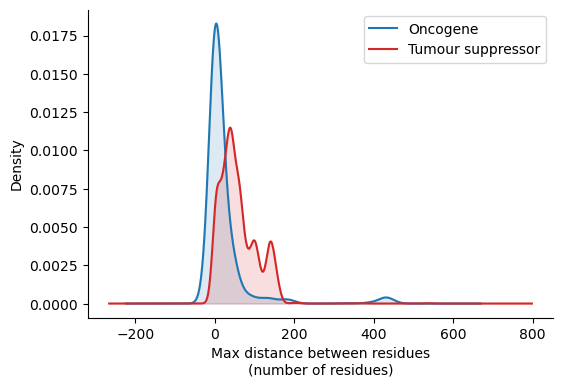

In [16]:
import pandas as pd

palette = {'Oncogene': 'C10', 'Tumour suppressor': 'C3', "Ambiguous" : "#ff6afe", 'Not annotated': 'darkgray'}

# Plot density distributions grouped by Gene_action
fig, ax = plt.subplots(figsize=(6, 4))
for name, group in df_distance.groupby('Gene_action'):
    distances = group['Max_distance']
    color = palette.get(name, 'black')
    if len(distances) > 1:
        distances.plot.kde(ax=ax, label=name, color=color)
        line = ax.get_lines()[-1]
        x, y = line.get_xdata(), line.get_ydata()
        ax.fill_between(x, y, color=color, alpha=0.15)
    else:
        ax.axvline(distances.iloc[0], linestyle='--', label=f"{name} (single)")

ax.set_xlabel('Max distance between residues\n(number of residues)')
ax.set_ylabel('Density')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [17]:
df_distance[df_distance["Gene"] == "KRAS"]

,Gene,Gene_action,Pos,Contacts,Max_distance
565,KRAS,Oncogene,12,[12],0
566,KRAS,Oncogene,61,[61],0
567,KRAS,Oncogene,12,"[12, 13]",1
568,KRAS,Oncogene,13,"[12, 13]",1
569,KRAS,Oncogene,61,[61],0
...,...,...,...,...,...
678,KRAS,Oncogene,61,"[59, 61]",2
679,KRAS,Oncogene,12,"[12, 13, 59]",46
680,KRAS,Oncogene,13,"[12, 13, 59]",46
681,KRAS,Oncogene,59,"[59, 61]",2


In [18]:
df_distance = df_res[["Gene", "Gene_action", "Pos", "Contacts", "Max_distance"]]
df_distance["Gene_action"] = df_distance.Gene_action.fillna("Not annotated")
# df_distance = df_distance[df_distance["Gene_action"] != "Ambiguous"].reset_index(drop=True)
df_distance

/tmp/ipykernel_981685/2428685383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distance["Gene_action"] = df_distance.Gene_action.fillna("Not annotated")


,Gene,Gene_action,Pos,Contacts,Max_distance
0,ACVR1,Oncogene,328,[328],0
1,ADGRV1,Not annotated,4500,"[4500, 4501]",1
2,ADGRV1,Not annotated,4501,"[4500, 4501]",1
3,ADGRV1,Not annotated,4503,"[4500, 4501, 4503, 4504]",2
4,ADGRV1,Not annotated,4504,"[4501, 4503, 4504]",2
...,...,...,...,...,...
4111,ZNF83,Not annotated,290,"[290, 293]",3
4112,ZNF83,Not annotated,293,"[290, 293]",3
4113,ZNF880,Not annotated,406,[406],0
4114,ZNF91,Not annotated,353,[353],0


/tmp/ipykernel_981685/4139731051.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distance['dist_bin'] = pd.cut(df_distance['Max_distance'], bins=bins, labels=labels, right=True)


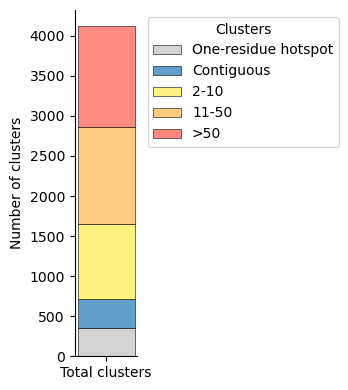

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


# 1. Define bins and labels
bins = [-0.1, 0, 1, 10, 50, df_distance['Max_distance'].max() + 1]
labels = ['One-residue hotspot', 'Contiguous', '2-10', '11-50', '>50']

# 2. Create a binned category column
df_distance['dist_bin'] = pd.cut(df_distance['Max_distance'], bins=bins, labels=labels, right=True)

# 3. Count clusters per bin in the specified order
counts = df_distance['dist_bin'].value_counts().reindex(labels).fillna(0).astype(int)

# 4. Define colors for each bin
colors = {
    'One-residue hotspot': '#D3D3D3',
    'Contiguous': '#629FCA',
    '2-10': '#fff280',
    '11-50': '#FFCC80',
    '>50': '#FF8A80'
}

# 5. Plot the stacked bar
fig, ax = plt.subplots(figsize=(3.7, 4))
bottom = 0
for label in labels:
    cnt = counts[label]
    ax.bar('Total clusters', cnt, bottom=bottom, color=colors[label], edgecolor='black', label=label, lw=0.4)
    bottom += cnt

# 6. Tidy up
ax.set_ylabel('Number of clusters')
ax.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

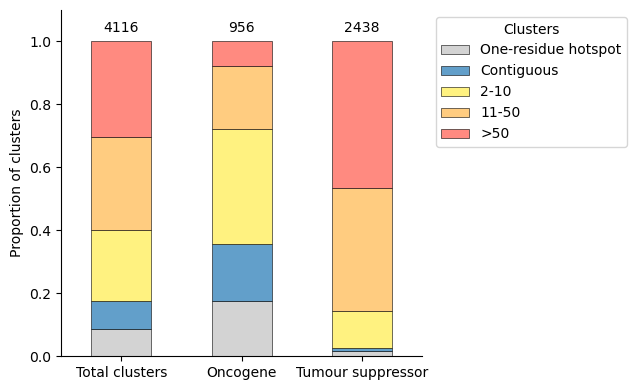

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and colors
labels = ['One-residue hotspot','Contiguous','2-10','11-50','>50']
color_map = {
    'One-residue hotspot':'#D3D3D3',
    'Contiguous'  :'#629FCA',
    '2-10'        :'#fff280',
    '11-50'       :'#FFCC80',
    '>50'         :'#FF8A80'
}

# 2. Which Gene_action to show individually
keep = ['Oncogene','Tumour suppressor']

# 3. Pivot counts for just those two
pivot_filt = (
    df_distance[df_distance['Gene_action'].isin(keep)]
    .groupby(['Gene_action','dist_bin'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=labels, fill_value=0)
)

# 4. Compute proportions
prop = pivot_filt.div(pivot_filt.sum(axis=1), axis=0)

# 5. Compute total counts (from the full df) and append
total_counts = df_distance['dist_bin'].value_counts().reindex(labels, fill_value=0)
prop.loc['Total clusters'] = total_counts / total_counts.sum()

# 6. Re-order so Total is first
order = ['Total clusters'] + keep
prop = prop.reindex(order)

# 7. Plot
fig, ax = plt.subplots(figsize=(6.5, 4))
prop.plot(
    kind='bar',
    stacked=True,
    color=[color_map[l] for l in labels],
    edgecolor='black',
    lw=0.4,
    ax=ax
)

# 8. Annotate raw totals
totals = [total_counts.sum()] + pivot_filt.sum(axis=1).reindex(keep).tolist()
for x, total in enumerate(totals):
    ax.text(x, 1.02, str(int(total)), ha='center', va='bottom')

# 9. Style
ax.set_ylabel('Proportion of clusters')
ax.set_xlabel(None)
ax.set_ylim(0,1.1)
ax.set_xticklabels(order, rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(title='Clusters', bbox_to_anchor=(1.02,1), loc='upper left')

plt.tight_layout()
plt.show()


# Tracks plot

In [21]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import json
import re
import sys

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

sys.path.append('../../')
from global_variables import SUBDIR, RUN, WORKSPACE

In [22]:
# Names and colors

colors_dict = {"Oncodrive3D" : "#ffad48", 
               "HotMAPS" : "#024b79", 
               "OncodriveCLUSTL" : "#43b7c2", 
               "smRegions" : "lightgray", 
               "CBaSE" : "lightgray", 
               "dNdScv" : "lightgray", 
               "MutPanning" : "lightgray", 
               "OncodriveFML" : "lightgray",
               "Random" : "pink"}

names_dict = {"o3d" : "Oncodrive3D", 
             "hotmaps" : "HotMAPS", 
             "clustl" : "OncodriveCLUSTL", 
             "smreg" : "smRegions", 
             "cbase" : "CBaSE", 
             "dndscv" : "dNdScv", 
             "mutpan" : "MutPanning", 
             "fml" : "OncodriveFML",
             "random" : "Random"}

In [23]:
## O3D RUN
input_path = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)
oncotree_df = pd.read_csv(f"{input_path}/oncotree.tsv", sep="\t")
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/output"
o3d_output_dir = f"{datasets}/cancer_202404/o3d_output/human_mane_raw/{RUN}"

## O3D DATA

# General
o3d_datasets = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506"
o3d_annotations = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/annotations_mane_240506"
o3d_seq_df = pd.read_table(f"{o3d_datasets}/seq_for_mut_prob.tsv")
o3d_annot_df = pd.read_table(f"{o3d_annotations}/uniprot_feat.tsv")
o3d_pdb_tool_df = pd.read_table(f"{o3d_annotations}/pdb_tool_df.tsv")
disorder_df = pd.read_table(f"{o3d_datasets}/confidence.tsv")
o3d_datasets_canonical = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_240506"
o3d_seq_df_canonical = pd.read_table(f"{o3d_datasets_canonical}/seq_for_mut_prob.tsv")

## Genes annot
uniq_drivers_df = pd.read_table(f"{input_path}/unique_drivers.tsv")
cgc_df = pd.read_csv(f"{input_path}/CGC_list_v99.tsv", sep = "\t")
oncokb_df = pd.read_csv(f"{input_path}/oncokb_list_20240712.tsv", sep = "\t")

cgc_genes = cgc_df["Gene Symbol"].unique()
intogen_genes = uniq_drivers_df.SYMBOL.unique()
oncokb_genes = oncokb_df["Hugo Symbol"].unique()

genetable_path = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/{SUBDIR}/{RUN}.genetable.tsv"
genetable = pd.read_csv(genetable_path, sep="\t")
genetable = genetable[[not cohort.startswith("ICGC") for cohort in genetable["Cohort"]]].reset_index(drop=True)
o3d_genes = genetable[genetable["o3d_qval"] < 0.01].Gene.unique()

/tmp/ipykernel_981685/171298557.py:16: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  o3d_pdb_tool_df = pd.read_table(f"{o3d_annotations}/pdb_tool_df.tsv")
/tmp/ipykernel_981685/171298557.py:17: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  disorder_df = pd.read_table(f"{o3d_datasets}/confidence.tsv")


## Get data

In [24]:
# Get only result from genes that were detected as significant in the cohort
def get_o3d_result(cohorts, o3d_output_dir):

    lst_dfs = []

    for cohort in cohorts:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
        path_genes_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        if os.path.exists(path_csv) and os.path.exists(path_genes_csv):

            # Get detected genes
            df_genes_cohort = pd.read_csv(path_genes_csv)
            df_genes_cohort = df_genes_cohort[df_genes_cohort["C_gene"] == 1] 
            genes_detected = df_genes_cohort.apply(lambda x: x.Gene, axis=1).values

            if len(genes_detected) > 0:
                # Get per-residue result
                df_cohort = pd.read_csv(path_csv)
                cols = ["Gene", "Uniprot_ID", "F", "Pos", "Mut_in_gene", "Score_obs_sim", "C", "C_ext", 'Cluster', 'Cancer', 'Cohort']
                df_cohort = df_cohort.loc[df_cohort.Gene.isin(genes_detected), cols]
                lst_dfs.append(df_cohort)
                
        else:
            print(f"Path doesn't exist: {path_csv}")

    return pd.concat(lst_dfs)

## Plot

In [25]:
plot_pars = {"fsize"                     : (12,9),
             "hspace"                    : 0.1,                    # General space between all tracks
             "track_title_x_coord"       : 0.83,                   # x-coordinate (respect to protein len) for track txt title
             "score_txt_x_coord"         : 1.13,                   # as track title but for track score txt
             "track_title_fontsize"      : 14,
             "ylabel_fontsize"           : 12,
             "xlabel_fontsize"           : 13.5,
             "ylabel_pad"                : 38,
             "ticksize"                  : 10.25,
             "legend_fontsize"           : 12,
             "legend_frameon"            : False,
             "y_labels_coord"            : [-0.15, 0.5],
             "cnsq_bbox_to_anchor"       : [1.1123, 0.9],
             "o3d_bbox_to_anchor"        : [1.27, 1.35],
             "depth_bbox_to_anchor"      : [1.086, -2.2, 1.4, 5.05],
             "depth_0_bbox_to_anchor"    : [1, -2.2, 0.35, 4.31],
             "legend_depth_fontsize"     : 10.5,
             "sse_bbox_to_anchor"        : [1.25, 3.6],
             "domain_bbox_to_anchor"     : [1.15, 15.5],                   
             "dpi"                       : 300,
             "sse_colors"                : {'Coil'   : "#d1d1d1", 
                                             'Helix'  : "#DDDD90", 
                                             'Ladder' : "#8ADEE6"
                                           }
            }

In [51]:
from matplotlib.lines import Line2D
import math
import string


def get_o3d_missense_mut_and_dict(o3d_pos_result):
    
    o3d_dict = {}
    for gene in o3d_pos_result.Gene.unique(): 
        o3d_dict[gene] = {}
        for cohort in o3d_pos_result[o3d_pos_result["Gene"] == gene].Cohort.unique():
            o3d_gene_cohort = o3d_pos_result.loc[(o3d_pos_result["Gene"] == gene) & (o3d_pos_result["Cohort"] == cohort)]
            o3d_dict[gene][cohort] = {}
            o3d_dict[gene][cohort]["Result"] = o3d_gene_cohort
            
            
    lst_gene_cohort = []
    for gene in o3d_dict.keys():
        for cohort in o3d_dict[gene].keys():
            lst_gene_cohort.append((cohort, gene))
    gene_cohort_df = pd.DataFrame(lst_gene_cohort, columns=["Cohort", "Gene"])
    gene_cohort_df = gene_cohort_df.groupby("Cohort")["Gene"].agg(list).reset_index()
    
    
    lst_missense_df = []
    for cohort, genes in gene_cohort_df[["Cohort", "Gene"]].values:
        cohort_missense_df = pd.read_table(f"{o3d_output_dir}/{cohort}/{cohort}.mutations.processed.tsv")
        cohort_missense_df = cohort_missense_df[cohort_missense_df["Gene"].isin(genes)].reset_index(drop=True)
        cohort_missense_df["Cohort"] = cohort
        lst_missense_df.append(cohort_missense_df)

    missense_df = pd.concat(lst_missense_df)
    missense_count_df = missense_df.groupby(['Gene', 'Pos']).size().reset_index(name='Count')
    
    return o3d_dict, missense_count_df


def write_defattr_file(attr_file_path, gene, uni_id, df_attr, attr_name="Conservation"):

    chimerax_sel_command = "sel :" + ",".join(map(str, gene_conservation_df.Pos.values))
    
    header = f"""#
#  Cluster conservation for {uni_id} ({gene})
#
#  Use this file to assign the attribute in Chimera with the 
#  Define Attribute tool or the command defattr.
#  {chimerax_sel_command}
#"""

    with open(attr_file_path, "w") as file:
        # Write the data to the file
        file.write(header)

    with open(attr_file_path, "a") as file:
        file.write(f"\nattribute: {attr_name}")
        file.write("\nrecipient: residues")

        for res, attr in zip(df_attr["Pos"], df_attr[attr_name]):
            file.write('\n\t:' + str(res) + '\t' + str(attr))
            

def get_o3d_gene_data(gene, 
                      seq_df, 
                      o3d_pos_df,
                      extend_clusters=True):
    
    # Subset gene
    seq_df_gene = seq_df[seq_df["Gene"] == gene]
    gene_len = len(seq_df_gene.Seq.values[0])
    gene_pos = pd.DataFrame({"Pos" : range(1, gene_len+1)})
    uni_id, af_f = seq_df_gene[["Uniprot_ID", "F"]].values[0]
    score_gene_df = o3d_pos_df[o3d_pos_df["Gene"] == gene].reset_index(drop=True)
    
    ## O3D score vector
    score_gene_df = gene_pos.merge(score_gene_df[["Pos", "Score_obs_sim", "C", "C_ext"]], how="left", on="Pos")

    # Clusters
    if extend_clusters:
        score_gene_df["C"] = (score_gene_df["C"] == 1).astype(int)
    else:
        score_gene_df["C"] = ((score_gene_df["C"] == 1) & (score_gene_df["C_ext"] == 0)).astype(int)
    score_gene_df = score_gene_df.drop(columns=["C_ext"])

    score_gene_df.columns = "Pos", "O3D_score", "Cluster"
    score_gene_df["O3D_score"] = score_gene_df["O3D_score"].fillna(0)
    score_gene_df["Cluster"] = score_gene_df["Cluster"].fillna(0)
    
    return score_gene_df


def add_consecutive_numbers(nums, max_n):

    result = []
    for i in range(len(nums)):
        result.append(nums[i])
        # Check if the current number is the start of a consecutive sequence
        if i < len(nums) - 1 and nums[i] + 1 != nums[i + 1]:
            result.append(nums[i] + 1)
            
    # Add the last consecutive number after the final element
    result.append(nums[-1] + 1)
    
    return result


def where_plus(condition):
    """
    Util function to extend the color of mpl filling to the next position.
    """
    
    ix = np.where(condition)[0]
    
    if len(ix) > 0:
        ix = add_consecutive_numbers(ix, max_n=len(condition))
        if len(condition) in ix:
            ix.remove(len(condition))
        boolean_vector = np.zeros(len(condition), dtype=bool)
        boolean_vector[ix] = True

        return pd.Series(boolean_vector)
    
    else:
        return condition


def clean_cohort_name(s):

    return re.sub(r"_(WXS|WES|WGS)|_\d+|\d+", "", s).replace("_", " ")


def is_gene_in_lst(gene, lst_genes, lst_name):
    
    return f"{lst_name}={'YES' if gene in lst_genes else 'NO'}"


def plot_tracks_plot(
    o3d_dict,
    mut_df,
    domain_df,
    disorder_df,
    pdb_tool_df,
    cohort_df,
    gene,
    plot_pars,
    o3d_seq_df,
    cohort,
    df_res_distance,
    title=None,
    alpha_scatter=1,
    figsize=(10,9),
    j_margin=15,
    hratio_one_cluster=0.05,
    hratio_needle=0.25,
    hspace_proportion=0.15,
    needle_ypad_ratio=0.1,
    len_txt_thr=2400,
    len_txt_thr_degron=600,
    absolute_score=False,
    extend_clusters=True,
    filename=None,
    return_conservation_df=False,
    predicted_degrons=False
    ):
    
    # Construct the full height ratios with the dynamic height for the second track
    df_distance = df_res_distance[(df_res_distance["Cohort"] == cohort) & (df_res_distance["Gene"] == gene)]
    o3d_result = o3d_dict[gene][cohort]["Result"]
    clusters_df = o3d_result[(o3d_result["C"] == 1) & (o3d_result["C_ext"] == 0)].reset_index(drop=True)
    clusters_df_all = o3d_result[o3d_result["C"] == 1].reset_index(drop=True)
    display(clusters_df_all)
    clusters = np.sort(clusters_df.Pos.values)
    n_clusters = len(clusters)
    
    hratio_one_cluster = 0.06 if n_clusters < 5 else hratio_one_cluster
    dynamic_height = hratio_one_cluster * n_clusters  
    
    h_ratios = [hratio_needle, dynamic_height, hratio_needle, 0.1, 0.1, 0.05, 0.05]
    base_height_per_unit = 6 
    total_height = sum(h_ratios) * base_height_per_unit
    hspace = hspace_proportion * base_height_per_unit / total_height
    gene_len = len(disorder_df)
    
    fig, axes = plt.subplots(
        len(h_ratios), 1, 
        figsize=(figsize[0], total_height),
        sharex=True, 
        gridspec_kw={'hspace': hspace, 
                    'height_ratios': h_ratios}
        )
    

    # Missense mutations
    # ==================

    n_max = np.max(mut_df["Count"])
    ax_ylim_min = 0-n_max*needle_ypad_ratio
    ax_ylim_max = n_max+n_max*needle_ypad_ratio
    axes[0].vlines(mut_df["Pos"], ymin=ax_ylim_min, ymax=mut_df["Count"], lw=1, zorder=1, alpha=0.5, color="lightgray")
    axes[0].scatter(mut_df["Pos"], mut_df["Count"], color='white', zorder=3, lw=1, ec="white") # To cover the overlapping needle top part
    axes[0].scatter(mut_df["Pos"], mut_df["Count"].values, zorder=4, 
                     alpha=alpha_scatter, lw=0.1, ec="black", s=60, color="#BDD7E7") ##FFDEB5 
    axes[0].set_ylim(ax_ylim_min, ax_ylim_max)
    axes[0].set_ylabel('Missense\nmutations count', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
    axes[0].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    axes[0].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])


    # Clusters
    # ========

    for i, pos in enumerate(clusters):
        axes[1].hlines(y=i, xmin=0, xmax=gene_len, linewidth=1, color='lightgray', alpha=1, zorder=0)

        contacts = df_distance[df_distance["Pos"] == pos].Contacts.values[0]
        
        # cluster_score = o3d_cohort_df[o3d_cohort_df["Cluster"] == 1].O3D_score.values 

        scatter = axes[1].scatter(y=np.repeat(i, len(contacts)), x=contacts,
                                # c=cluster_score, cmap='Reds', 
                                # vmin=score_min if absolute_score else None, 
                                # vmax=score_max if absolute_score else None,
                                # label=cohort,  
                                zorder=2, lw=0.2,
                                alpha=alpha_scatter, ec="black", 
                                c=["red" if p == pos else "lightgray" for p in contacts],
                                s=[80 if p == pos else 50 for p in contacts])   # color=sns.color_palette("tab20", 20)[i]

    # Build two proxy artists:
    legend_elements = [
        Line2D(
            [0], [0],
            marker='o', linestyle='',
            markeredgewidth=0.2,
            markerfacecolor='lightgray',
            markeredgecolor='black',
            markersize=math.sqrt(50),  # scatter s=50 → diameter ≈ sqrt(50)
            label="Mutated residue in the volume"
        ),
        Line2D(
            [0], [0],
            marker='o', linestyle='',
            markeredgewidth=0.2,
            markerfacecolor='red',
            markeredgecolor='black',
            markersize=math.sqrt(80),  # scatter s=80 → diameter ≈ sqrt(80)
            label="Center of the volume"
        ),
    ]

    axes[1].legend(
        handles=legend_elements,
        loc="best",
        title="Residues in clusters",
        bbox_to_anchor=(0.95 if gene != "KRAS" else 1.35, 1),
        frameon=False,
        fontsize=10.5,
        title_fontsize=plot_pars["legend_fontsize"], 
    )
    
    if n_clusters < 5:
        axes[1].set_ylim(-1, n_clusters)
    axes[1].set_yticks(np.arange(len(clusters)))
    axes[1].set_yticklabels(clusters)
    axes[1].set_ylabel('Cluster position', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
    axes[1].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])


    # Clumps
    # ======
    
    ax = 2

    max_score = np.max(clusters_df_all["Score_obs_sim"])
    ax_ylim_min = 0-max_score*needle_ypad_ratio
    ax_ylim_max = max_score+max_score*needle_ypad_ratio
    clump_ypad_ratio = 0.9 if max_score < 15 else 2 if max_score < 40 else 6
    axes[ax].vlines(clusters_df_all["Pos"], ymin=ax_ylim_min, ymax=clusters_df_all["Score_obs_sim"], lw=1, zorder=1, alpha=0.5, color="lightgray")
    scatter = axes[ax].scatter(y=clusters_df_all["Score_obs_sim"], 
                                        x=clusters_df_all["Pos"], 
                                        c=[f"C{int(c)}" for c in clusters_df_all["Cluster"].values], 
                                        vmin=0, vmax=1,
                                        zorder=2, lw=0.2, alpha=alpha_scatter, ec="black", s=60)
    axes[ax].set_ylim(ax_ylim_min, ax_ylim_max)
    axes[ax].set_ylabel('Clumps\nand\n3D clustering score', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
    axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])

    clumps = sorted(clusters_df_all["Cluster"].unique())
    letters = string.ascii_uppercase
    cluster_labels = {c: letters[i] for i, c in enumerate(clumps)}

    handles = []
    for c in clumps:
        handles.append(
            Line2D(
                [0], [0],
                marker='o',
                color='w',                     
                markerfacecolor=f"C{int(c)}",     
                markeredgecolor="black",        
                markeredgewidth=0.2,
                markersize=math.sqrt(60),                    
                label=f"{cluster_labels[c]}"
            )
        )

    axes[ax].legend(
        handles=handles,
        title="Clumps",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0,
        frameon=False,
        fontsize=10.5,
        ncols= 1 if len(clumps) < 4 else 2,
        title_fontsize=plot_pars["legend_fontsize"]
    )

    # Track pACC
    # ==========

    ax=3

    if isinstance(pdb_tool_df, pd.DataFrame):
        max_pacc = np.max(pdb_tool_df["pACC"].fillna(0))
        axes[ax].fill_between(pdb_tool_df["Pos"], 0, pdb_tool_df["pACC"].fillna(0),                  
                              zorder=2, color=sns.color_palette("pastel")[4], alpha=0.35)
        axes[ax].set_ylabel('Solvent\naccessibility', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()


    # pLDDT
    # ==========

    ax=4

    if isinstance(disorder_df, pd.DataFrame):
        max_pacc = np.max(disorder_df["Confidence"].fillna(0))
        axes[ax].fill_between(disorder_df["Pos"], 0, disorder_df["Confidence"].fillna(0),                  
                              zorder=2, color=sns.color_palette("pastel")[4], alpha=0.35)
        axes[ax].set_ylabel('pLDDT', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()


    # Track SSE
    # =========

    ax=5
   
    if isinstance(pdb_tool_df, pd.DataFrame):
        for n, sse in enumerate(('Coil', 'Helix', 'Ladder')):   
            axes[ax].fill_between(pdb_tool_df["Pos"], 0, 1, where=(pdb_tool_df['SSE'] == sse),
                                  zorder=2, color=plot_pars["sse_colors"][sse], 
                                  alpha=1, 
                                  label=sse, 
                                  lw=4.2 if gene_len < 200 else 3.4 if gene_len < 300 else 2.2 if gene_len < 450 else 1.7 if gene_len < 1000 else 1)
        axes[ax].set_yticks([])  
        axes[ax].legend(fontsize=10.5, frameon=plot_pars["legend_frameon"], 
                        bbox_to_anchor=plot_pars["sse_bbox_to_anchor"], title = "Secondary structure", 
                        title_fontsize=plot_pars["legend_fontsize"], 
                        handleheight=0.67, handlelength=2, markerscale=1) 
        axes[ax].set_ylabel('Secondary structure', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()


    # Track Domain
    # ============

    ax=6

    if isinstance(domain_df, pd.DataFrame):
        domain_color_dict = {}
        genes_clashing_domains = ["KDM6A", "XPO1"]

        for n, name in enumerate(domain_df["Description"].unique()):
            domain_color_dict[name] = f"C{n}"

        n = 0
        added_domain = []
        for i, row in domain_df.iterrows():
            if pd.Series([row["Description"], row["Begin"], row["End"]]).isnull().any():
                continue

            name = row["Description"]
            start = int(row["Begin"])
            end = int(row["End"])
            
            if name not in added_domain and (gene_len >= len_txt_thr or gene in genes_clashing_domains):
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=domain_color_dict[name], label=name, lw=0.5)
            else:
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=domain_color_dict[name], lw=0.5)
            
            if name not in added_domain:
                if gene_len < len_txt_thr and gene not in genes_clashing_domains:
                    y = -0.04
                    axes[ax].text(((start + end) / 2)+0.5, y, name, ha='center', va='center', fontsize=10, color="black")
                added_domain.append(name)
        axes[ax].set_yticks([])  
        if (gene_len >= len_txt_thr or gene in genes_clashing_domains) and len(added_domain) > 0:
            axes[ax].legend(fontsize=10.5, frameon=plot_pars["legend_frameon"], loc="lower center",
                            bbox_to_anchor=plot_pars["domain_bbox_to_anchor"], title = "Domain", 
                            title_fontsize=plot_pars["legend_fontsize"],
                            handleheight=0.67, handlelength=2) 
        axes[ax].set_ylabel('Domain', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()

    # if ix == 1:
    #     axes[ax+ix].remove()
    #     axes[-2].tick_params(labelbottom=True)
    #     axes[-2].set_xlabel("Protein position", fontsize=plot_pars["ylabel_fontsize"])
    # else:
    #     axes[-1].set_xlabel("Protein position", fontsize=plot_pars["ylabel_fontsize"])

    
    # Details
    # =======

    if gene is not None:
        fig.suptitle(title, y=0.905, x=0.44)

    for n in range(4):
        axes[n].spines['top'].set_visible(False)
        axes[n].spines['right'].set_visible(False)

    if filename:
        plt.savefig(filename, dpi=600, bbox_inches='tight')

    plt.show()

/tmp/ipykernel_981685/3774489268.py:20: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cohort = pd.read_csv(path_csv)


Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_pos.csv


,Gene,Uniprot_ID,F,Pos,Mut_in_gene,Score_obs_sim,C,C_ext,Cluster,Cancer,Cohort
0,TP53,K7PPA8,1,239,42,7.710469,1,0.0,0.0,NaN,TCGA_WXS_UCS
1,TP53,K7PPA8,1,242,42,7.981828,1,0.0,0.0,NaN,TCGA_WXS_UCS
2,TP53,K7PPA8,1,245,42,8.411105,1,0.0,0.0,NaN,TCGA_WXS_UCS
3,TP53,K7PPA8,1,241,42,8.469888,1,0.0,0.0,NaN,TCGA_WXS_UCS
4,TP53,K7PPA8,1,248,42,7.078548,1,0.0,0.0,NaN,TCGA_WXS_UCS
5,TP53,K7PPA8,1,249,42,6.728561,1,0.0,0.0,NaN,TCGA_WXS_UCS
6,TP53,K7PPA8,1,243,42,6.548845,1,0.0,0.0,NaN,TCGA_WXS_UCS
7,TP53,K7PPA8,1,273,42,6.713049,1,0.0,0.0,NaN,TCGA_WXS_UCS
8,TP53,K7PPA8,1,238,42,6.907219,1,0.0,0.0,NaN,TCGA_WXS_UCS
9,TP53,K7PPA8,1,175,42,5.890060,1,0.0,0.0,NaN,TCGA_WXS_UCS


/tmp/ipykernel_981685/2423184317.py:278: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = axes[ax].scatter(y=clusters_df_all["Score_obs_sim"],


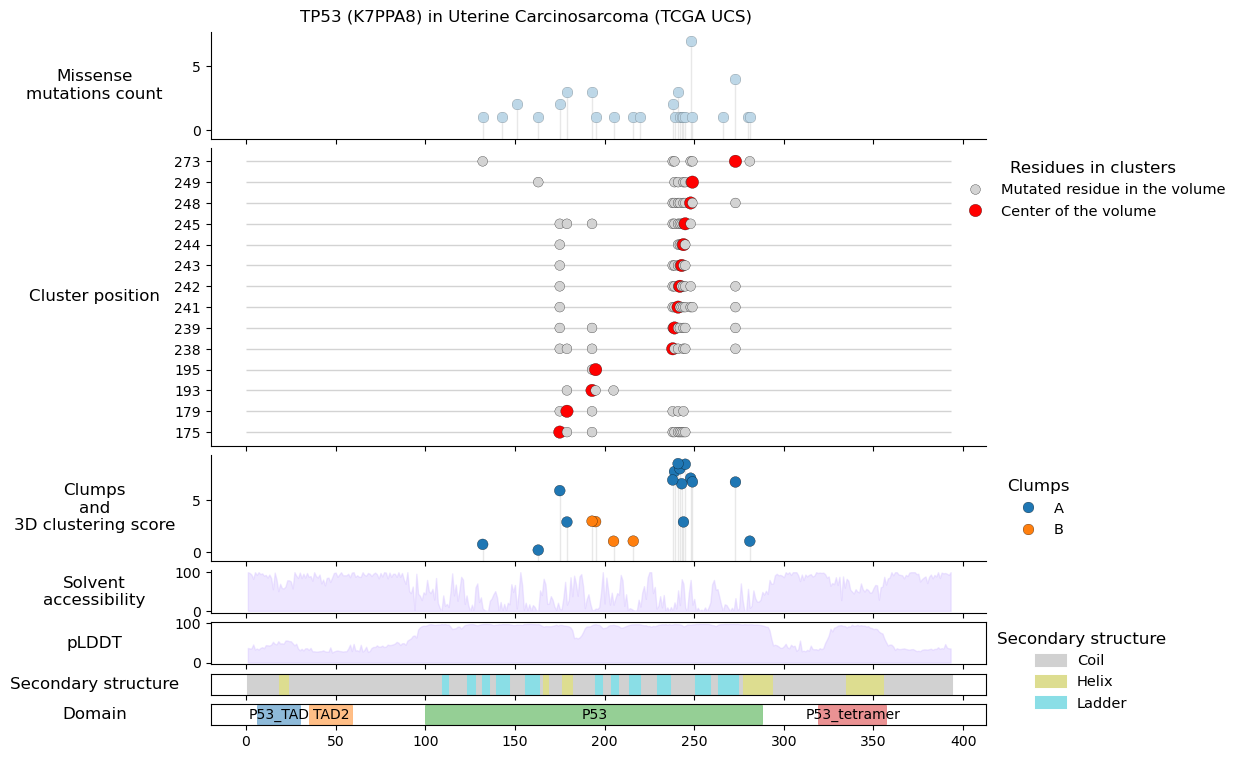

/tmp/ipykernel_981685/3774489268.py:20: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cohort = pd.read_csv(path_csv)


Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_pos.csv


,Gene,Uniprot_ID,F,Pos,Mut_in_gene,Score_obs_sim,C,C_ext,Cluster,Cancer,Cohort
0,KRAS,A0A024RAV5,1,12,202,57.965763,1,0.0,0.0,NaN,TCGA_WXS_COADREAD
1,KRAS,A0A024RAV5,1,13,202,59.613520,1,0.0,0.0,NaN,TCGA_WXS_COADREAD
2,KRAS,A0A024RAV5,1,61,202,54.589192,1,0.0,0.0,NaN,TCGA_WXS_COADREAD
3,KRAS,A0A024RAV5,1,59,202,53.277986,1,0.0,0.0,NaN,TCGA_WXS_COADREAD
4,KRAS,A0A024RAV5,1,34,202,0.001206,1,1.0,0.0,NaN,TCGA_WXS_COADREAD


/tmp/ipykernel_981685/2423184317.py:278: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = axes[ax].scatter(y=clusters_df_all["Score_obs_sim"],


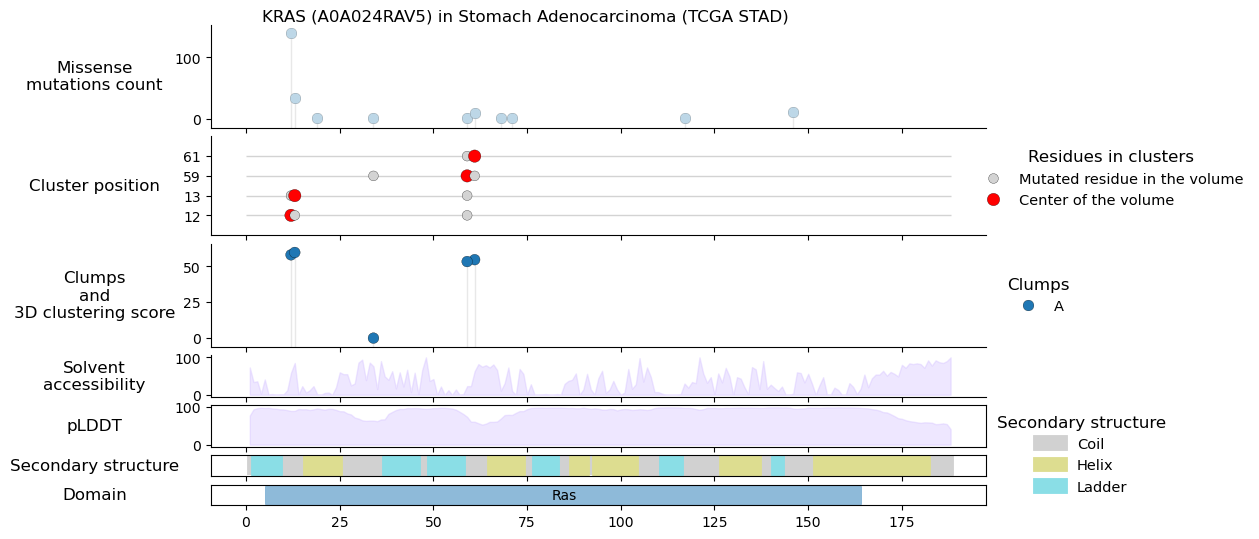

/tmp/ipykernel_981685/3774489268.py:20: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cohort = pd.read_csv(path_csv)


Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_pos.csv


,Gene,Uniprot_ID,F,Pos,Mut_in_gene,Score_obs_sim,C,C_ext,Cluster,Cancer,Cohort
0,PIK3CA,P42336,1,545,242,20.079184,1,0.0,0.0,NaN,TCGA_WXS_UCEC
1,PIK3CA,P42336,1,1049,242,16.184803,1,0.0,1.0,NaN,TCGA_WXS_UCEC
2,PIK3CA,P42336,1,1047,242,16.817356,1,0.0,1.0,NaN,TCGA_WXS_UCEC
3,PIK3CA,P42336,1,1044,242,17.429616,1,0.0,1.0,NaN,TCGA_WXS_UCEC
4,PIK3CA,P42336,1,1043,242,17.283906,1,0.0,1.0,NaN,TCGA_WXS_UCEC
5,PIK3CA,P42336,1,542,242,17.448553,1,0.0,2.0,NaN,TCGA_WXS_UCEC
6,PIK3CA,P42336,1,546,242,14.852509,1,0.0,0.0,NaN,TCGA_WXS_UCEC
7,PIK3CA,P42336,1,88,242,6.216724,1,0.0,3.0,NaN,TCGA_WXS_UCEC
8,PIK3CA,P42336,1,539,242,5.571316,1,0.0,2.0,NaN,TCGA_WXS_UCEC
9,PIK3CA,P42336,1,39,242,5.346951,1,0.0,3.0,NaN,TCGA_WXS_UCEC


/tmp/ipykernel_981685/2423184317.py:278: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = axes[ax].scatter(y=clusters_df_all["Score_obs_sim"],


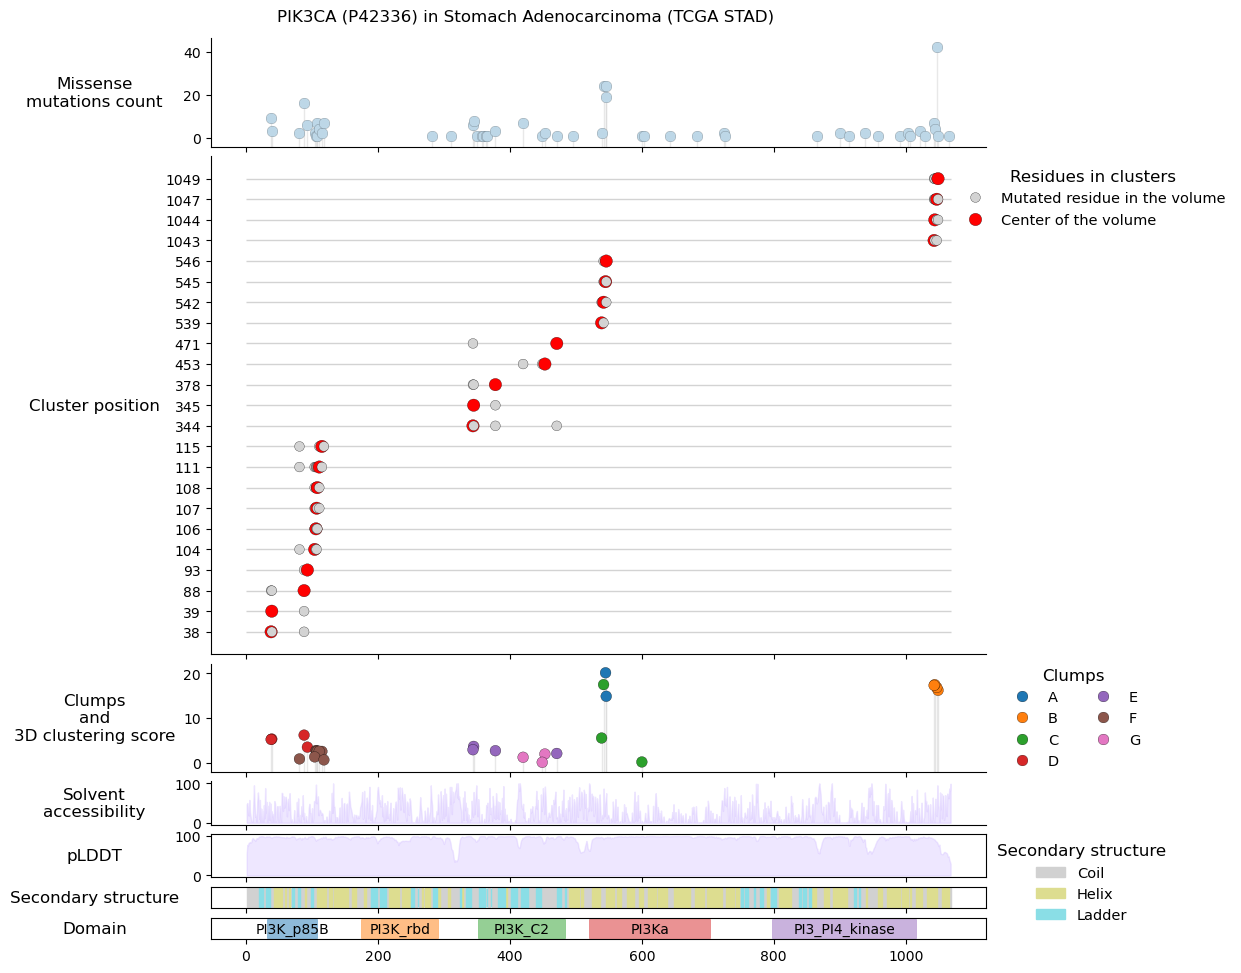

In [52]:
cohort_names = ["Uterine Carcinosarcoma (TCGA UCS)", "Stomach Adenocarcinoma (TCGA STAD)", "Stomach Adenocarcinoma (TCGA STAD)"]
genes = ["TP53", "KRAS", "PIK3CA"]
cohorts = ["TCGA_WXS_UCS", "TCGA_WXS_COADREAD", "TCGA_WXS_UCEC"]

for i, (gene, cohort) in enumerate(zip(genes, cohorts)):
    o3d_pos_result = get_o3d_result(cohort_df["COHORT"].values, o3d_output_dir)
    o3d_pos_result = o3d_pos_result[o3d_pos_result["Cohort"] == cohort].reset_index(drop=True)
    o3d_dict, missense_count_df = get_o3d_missense_mut_and_dict(o3d_pos_result)

    uni_id, tr_id = o3d_seq_df.loc[o3d_seq_df["Gene"] == gene, ["Uniprot_ID", "Ens_Transcr_ID"]].values[0]
    pdb_tool_gene = o3d_pdb_tool_df[o3d_pdb_tool_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
    domain_gene = o3d_annot_df[
        (o3d_annot_df["Gene"] == gene) & 
        (o3d_annot_df["Type"] == "DOMAIN") & 
        (o3d_annot_df["Evidence"] == "Pfam")
        ].reset_index(drop=True)
    disorder_gene = disorder_df[disorder_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
    
    cohort_df_gene = cohort_df[cohort_df.COHORT.isin(o3d_dict[gene].keys())]

    title = f"{gene} ({uni_id}) in {cohort_names[i]}" 
    missense_gene_df = missense_count_df[missense_count_df["Gene"] == gene]

    gene_conservation_df = plot_tracks_plot(
        o3d_dict,
        missense_gene_df,
        domain_gene, 
        disorder_gene,
        pdb_tool_gene,
        cohort_df_gene,
        gene,
        plot_pars,
        o3d_seq_df,
        df_res_distance=df_res,
        cohort=cohort,
        figsize=(10,8),
        title=title,
        absolute_score=True,
        extend_clusters=True,
        return_conservation_df=True,
        filename=None
        )